In [100]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications import DenseNet121
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu, sigmoid
from keras.optimizers import Adam

from keras.layers import BatchNormalization

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
ZOOM         = 0.85
NUM_CLASSES  = 5

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

# the main dataframes
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")

df_2015["id_code"]   = df_2015.image
df_2015["diagnosis"] = df_2015.level

train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2)
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2)


Text(0.5, 1.0, 'Samples Per Class')

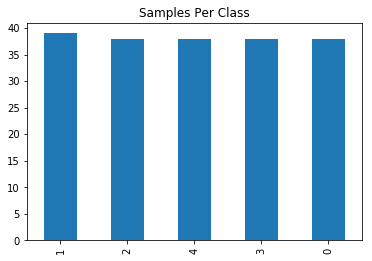

In [101]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)


class_to_val = [[0.85, 0.1, 0.05, 0, 0],
                [0.1, 0.8, 0.1, 0, 0],
                [0, 0.15, 0.7, 0.15, 0],
                [0, 0, 0.1, 0.8, 0.1], 
                [0, 0, 0.05, 0.1, 0.85]]

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    for i in range(5):
        train[str(i)] = train.diagnosis.apply(lambda x: class_to_val[x][i])
        valid[str(i)] = valid.diagnosis.apply(lambda x: class_to_val[x][i])

    valid.diagnosis = valid.diagnosis.astype('str')
    train.diagnosis = train.diagnosis.astype('str')

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == str(diagnosis)].index
            indexes_train = train[train['diagnosis'] == str(diagnosis)].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution later
    train = train.sample(frac=1)
    valid = valid.sample(frac=1)
    
    return train, valid

# plot example
_, df_to_plot = get_train_valid_df(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')

# df_to_plot.columns

In [73]:
def squareUp(rgb):
    
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    thresh = 5
    
    # remove any black regions, where black is y under the threshold
    rowMaxes = gray.max(axis=1)
    top = 0
    while rowMaxes[top] < thresh:
        top += 1
    bottom = len(rowMaxes) - 1
    while rowMaxes[bottom] < thresh:
        bottom -= 1
        
    middleRow = gray[int((bottom-top)/2)]
    left = 0
    while middleRow[left] < thresh:
        left += 1
    right = len(middleRow) - 1
    while middleRow[right] < thresh:
        right -= 1
        
    height = bottom - top
    width  = right - left
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return rgb
    
    rgb = rgb[top:bottom, left:right]
    
    return cv2.resize(rgb, (IMG_DIM, IMG_DIM))

# assumes RGB
def colourfulEyes(img, weight=4, gamma=15):
    
    # crop out black - no point if we are zooming in anyway
#     img = squareUp(img) 
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, weight, cv2.GaussianBlur(y, (0,0), gamma), -weight, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified 

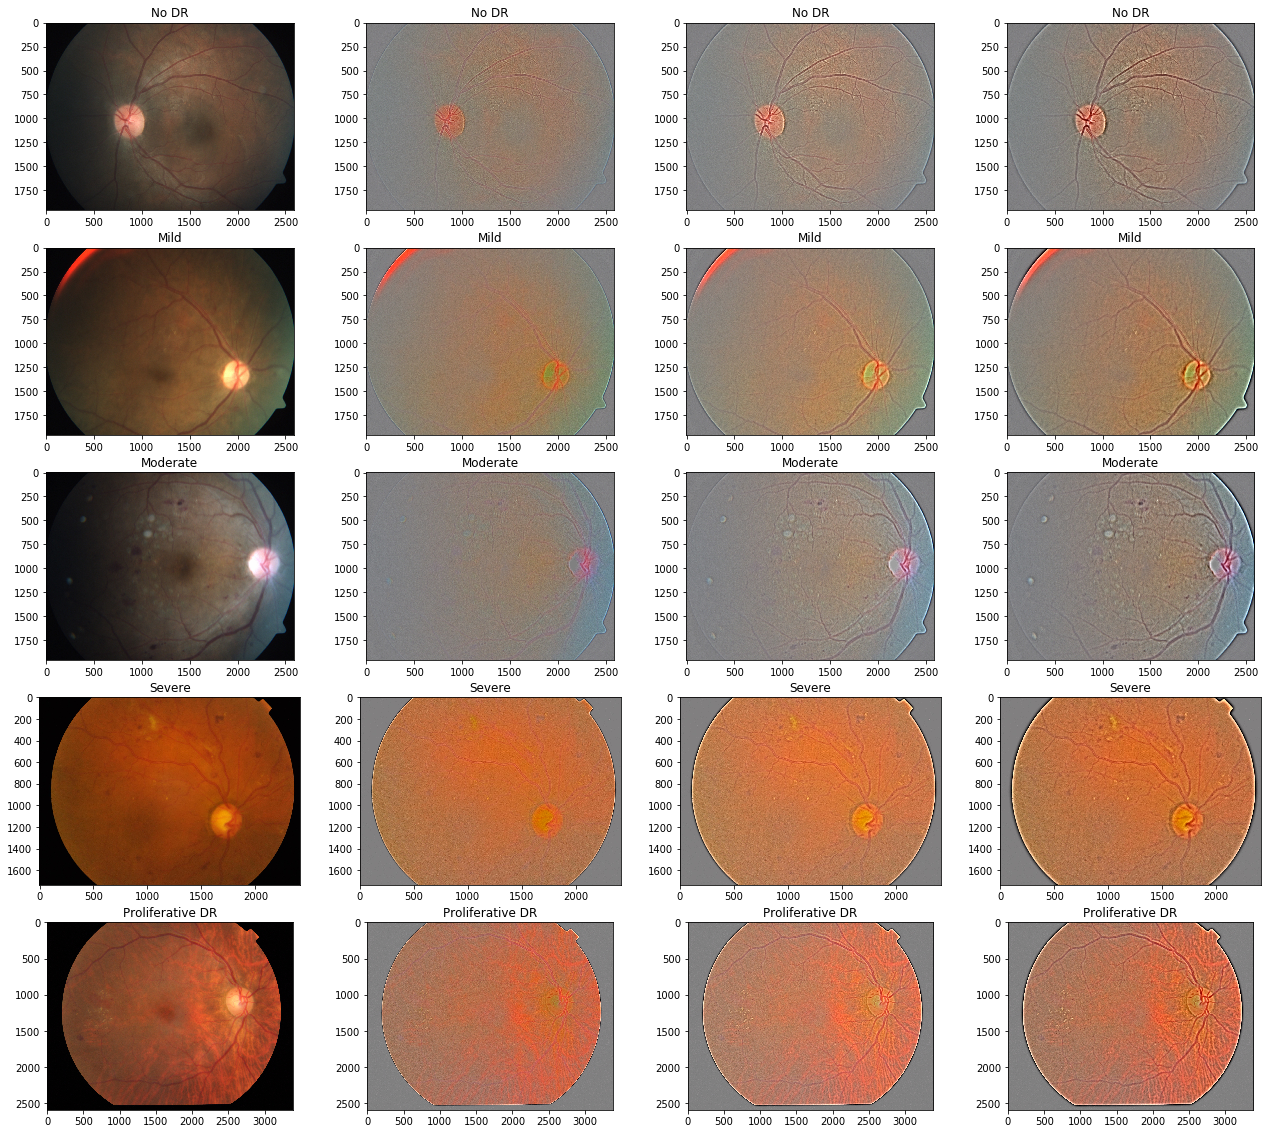

In [74]:
#display some data
df_example = getDF(year="2019")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_example['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
                                    .sample(1)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        
        # colored versions with diff gammas
        funky = colourfulEyes(rgb, 4, 5)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+2)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])

        # colored version
        funky = colourfulEyes(rgb, 4, 10)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+3)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])

        # colored version
        funky = colourfulEyes(rgb, 4, 15)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+4)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])


In [106]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True, 
                                       vertical_flip=True,
                                       rotation_range=360,
#                                        width_shift_range=jitter,
#                                        height_shift_range=jitter,
#                                        shear_range=jitter/2,
                                       zoom_range=[(1-jitter)*ZOOM, (1+jitter)*ZOOM],
                                       fill_mode="reflect",
                                       preprocessing_function=colourfulEyes
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", class_mode="raw",
                                       y_col=["0", "1", "2", "3", "4"],
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019"):
    
    train, valid = get_train_valid_df(year=year) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen, train, valid

gc.collect()


613

Found 775 validated image filenames.
Found 190 validated image filenames.


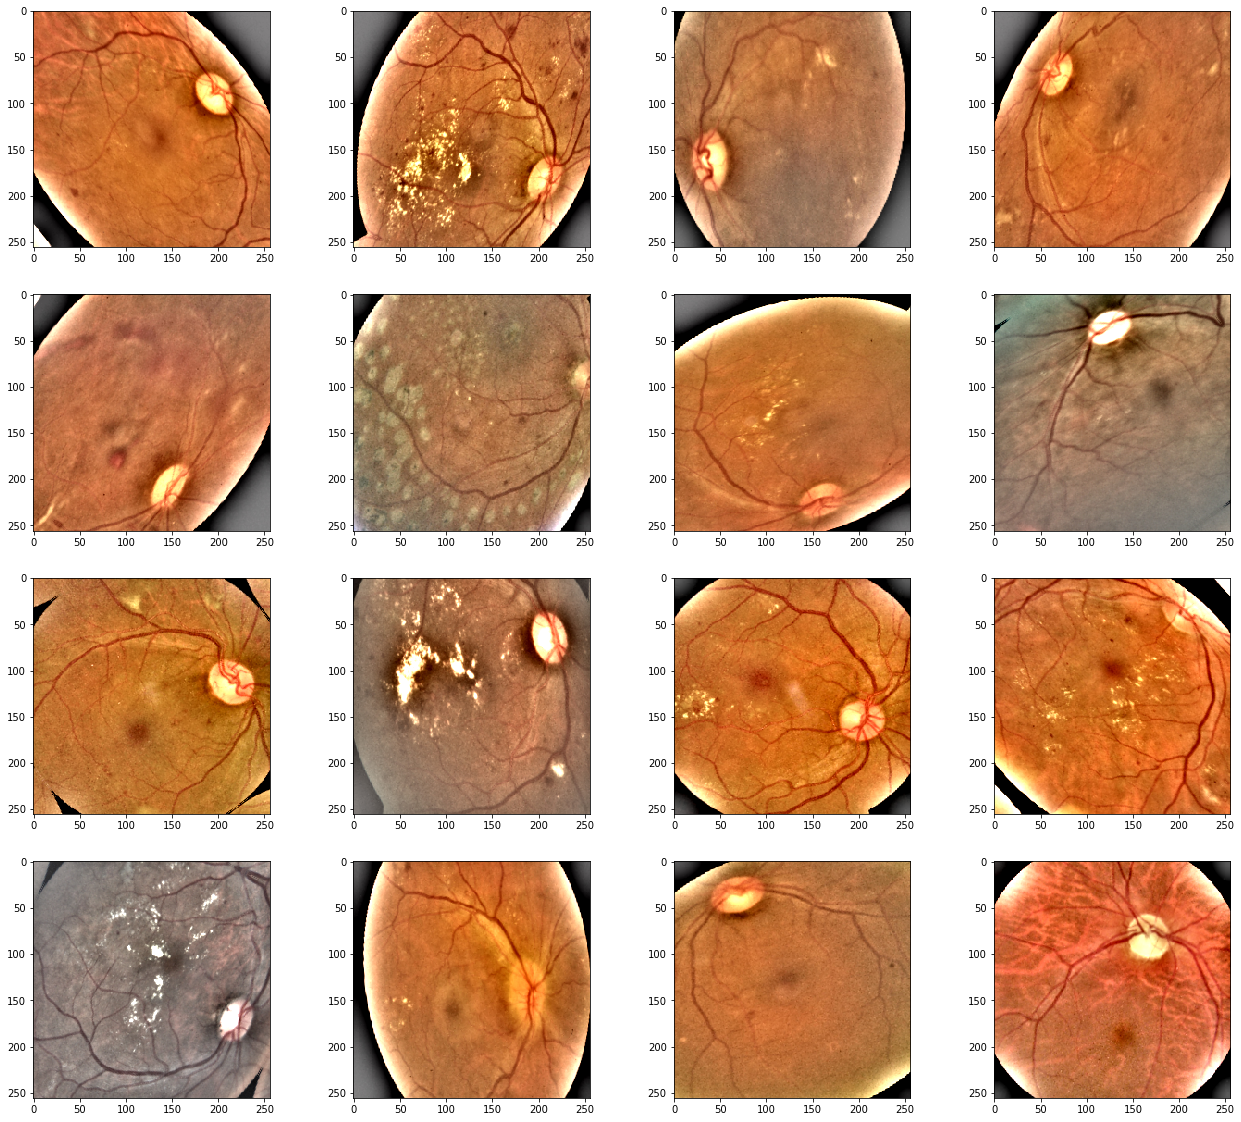

In [90]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05)

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [108]:
class Metrics(Callback):
    def __init__(self, generator, df):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        predict_val = model.predict_generator(self.generator, 
                                              steps=self.generator.n//self.generator.batch_size, 
                                              verbose=1)
        numBatches = 5
        val_kappa  = 0
        for x, y in self.generator:
            predictions = model.predict(x)
            y_pred = np.argmax(predictions, axis=1)
            y_val  = np.argmax(y, axis=1)
            val_kappa += cohen_kappa_score(y_val, y_pred, weights='quadratic')/5
            
            numBatches -= 1
            if numBatches == 0:
                break
            
        print(y_val[:5], predictions[:5])

            
        self.val_kappas.append(val_kappa)
        print(f"val_kappa: {val_kappa:.4f}")

        if val_kappa == max(self.val_kappas):
            print("Max of this run, saving model.")
            model.save(f"densenet_new-{val_kappa:.4f}.h5")


In [91]:
def create_model(img_dim, CHANNELS, n_class):
    
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
    base_model = DenseNet121(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../DenseNet-BC-121-32-no-top.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512,  activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model = Model(input_tensor, output_layer)
    
    return model

model=create_model(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)
# model.load_weights("densenet-0.9333.h5") # with 300 imgsize



In [92]:
# todo: don't think this is thinking of frozen layers
# for layers in model.layers:
#     layers.trainable = True

model.compile(optimizer=Adam(lr=0.00005), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
gc.collect()

34972

In [ ]:
for year in ["2019", "2015", "2019", "2019", "2019"]:

    # these need to be global for the kappa callback
    train_generator, valid_generator, train, valid = generator(jitter=0.1, year=year)

    # Call backs during training            
    kappa_callbacks = Metrics(valid_generator, valid)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                   min_lr=1e-7, mode='auto', verbose=1)

    # train the model for 12 epochs
    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                  validation_data=valid_generator,
                                  validation_steps=valid_generator.n // valid_generator.batch_size,
                                  epochs=4,
                                  callbacks=[early_stop, reduce_lr, kappa_callbacks],
                                  verbose=1
                                 )
    gc.collect()

Found 776 validated image filenames.
Found 191 validated image filenames.
Epoch 1/4
5/5 [==============================] - 44s 9s/step
[4 4 3 1 1] [[1.38204712e-02 3.35820578e-02 4.96373087e-01 3.02817613e-01
  1.53406844e-01]
 [6.36981800e-04 5.49041491e-04 7.55148521e-03 4.06780019e-02
  9.50584531e-01]
 [8.93610530e-03 9.14879143e-02 1.76937655e-01 4.90778804e-01
  2.31859505e-01]
 [2.10578829e-01 3.55979353e-01 2.20237985e-01 6.20479323e-02
  1.51155949e-01]
 [1.76617533e-01 1.72724187e-01 2.32766926e-01 1.21812575e-01
  2.96078742e-01]]
val_kappa: 0.7105
Max of this run, saving model.
Epoch 2/4
5/5 [==============================] - 43s 9s/step
[0 1 3 2 3] [[9.9345243e-01 2.5996659e-03 5.7416479e-04 2.8702144e-03 5.0356612e-04]
 [3.6052790e-02 1.4626890e-01 8.0520190e-02 2.3395997e-01 5.0319821e-01]
 [4.4864800e-02 6.3485771e-02 2.1876507e-01 3.7423417e-01 2.9865021e-01]
 [8.5420722e-01 4.6899933e-02 5.1120386e-02 2.7190579e-02 2.0581847e-02]
 [3.4212708e-02 6.1618701e-02 1.689493

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255,
                                        zoom_range=[ZOOM, ZOOM],
                                        preprocessing_function=colourfulEyes
                                       )

test_generator = test_datagen.flow_from_dataframe(dataframe = df_train,
                                                  directory = "../aptos2019/train_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False, 
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
preds = model_resnet.predict_generator(generator=test_generator, steps=50)
preds, df_train